# Complex Mosaicing


Optimizes the image coverage search to avoid scene overlaps. Only downloads the neccessary parts.

Download the overlap area, and each unique area. Each in one job. For the overlap area the scene with the lowest cloudcover.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import copy

import geopandas as gpd
%matplotlib inline
import matplotlib.pyplot as plt
import rasterio
from rasterio.merge import merge
import pandas as pd
import area

import up42

In [2]:
# Catalog currently only works with account authentification!
api = up42.authenticate(cfg_file="config.json", env="dev")

2020-04-02 12:45:37,277 - up42.auth - INFO - Got credentials from config file.
2020-04-02 12:45:37,554 - up42.auth - INFO - Authentication with UP42 successful!


In [3]:
outdir = Path.cwd() / "dakar_complex_pleiades"
outdir.mkdir(parents=True, exist_ok=True)

## Define aoi

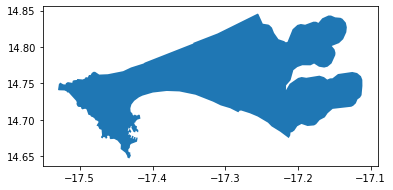

In [4]:
aoi = up42.read_vector_file("dakar.geojson", as_dataframe=True)
aoi.plot()

## Search available images

2020-04-02 12:45:37,833 - up42.catalog - INFO - Searching catalog with: {'datetime': '2018-08-02T00:00:00Z/2020-08-09T00:00:00Z', 'intersects': {'type': 'Polygon', 'coordinates': (((-17.529857, 14.741202), (-17.528703, 14.748847), (-17.52686, 14.751031), (-17.522855, 14.748707), (-17.519673, 14.748374), (-17.518791, 14.750683), (-17.517314, 14.750686), (-17.516981, 14.751799), (-17.510855, 14.750763), (-17.509799, 14.751426), (-17.509903, 14.753229), (-17.508237, 14.754202), (-17.503933, 14.754674), (-17.503399, 14.756024), (-17.496004, 14.755294), (-17.492911, 14.756651), (-17.491767, 14.758595), (-17.489119, 14.758018), (-17.487241, 14.76154), (-17.485135, 14.761315), (-17.483361, 14.764372), (-17.48083, 14.76595), (-17.478857, 14.765801), (-17.473266, 14.762048), (-17.461401, 14.762555), (-17.440347, 14.766725), (-17.429603, 14.77182), (-17.412524, 14.777208), (-17.41046, 14.77862), (-17.343999, 14.804732), (-17.343829, 14.805709), (-17.310555, 14.818605), (-17.255434, 14.845886), (

,index,geometry,id,acquisitionDate,constellation,providerName,blockNames,cloudCoverage,providerProperties,scene_id
0,0,"POLYGON ((-17.64699 14.82726, -17.45205 14.833...",5a0ef1b8-47d3-4185-adb7-cfd1f1919ab4,2019-03-06T11:54:29Z,PHR,oneatlas,"[oneatlas-pleiades-fullscene, oneatlas-pleiade...",0.0,"{'commercialReference': 'SO19007000-022', 'acq...",DS_PHR1B_201903061154299_FR1_PX_W018N14_0618_0...
1,1,"POLYGON ((-17.33060 14.99399, -17.13627 14.989...",b23f1aee-2f9d-42f7-9289-5d1869ddb419,2019-03-06T11:54:02Z,PHR,oneatlas,"[oneatlas-pleiades-fullscene, oneatlas-pleiade...",0.0,"{'commercialReference': 'SO19007000', 'acquisi...",DS_PHR1B_201903061154025_FR1_PX_W018N14_1020_0...
2,3,"POLYGON ((-17.66357 14.83658, -17.43370 14.826...",5f6f8e86-aa79-490d-8fbe-cb3d43437ad1,2018-11-21T12:02:04Z,PHR,oneatlas,"[oneatlas-pleiades-fullscene, oneatlas-pleiade...",0.0,"{'commercialReference': 'SO18031888', 'acquisi...",DS_PHR1A_201811211202043_FR1_PX_W018N14_0618_0...
3,4,"POLYGON ((-17.55564 14.83393, -17.32354 14.809...",6da2189e-ead4-4edf-9937-8d468c782553,2018-11-21T12:01:48Z,PHR,oneatlas,"[oneatlas-pleiades-fullscene, oneatlas-pleiade...",0.0,"{'commercialReference': 'SO18031888', 'acquisi...",DS_PHR1A_201811211201489_FR1_PX_W018N14_0718_0...
4,5,"POLYGON ((-17.53273 14.81166, -17.34626 14.812...",3e602dbe-9990-4a30-9d09-7fc100a24529,2018-12-12T11:50:56Z,PHR,oneatlas,"[oneatlas-pleiades-fullscene, oneatlas-pleiade...",0.0,"{'commercialReference': 'SO18034670', 'acquisi...",DS_PHR1A_201812121150564_FR1_PX_W018N14_0718_0...


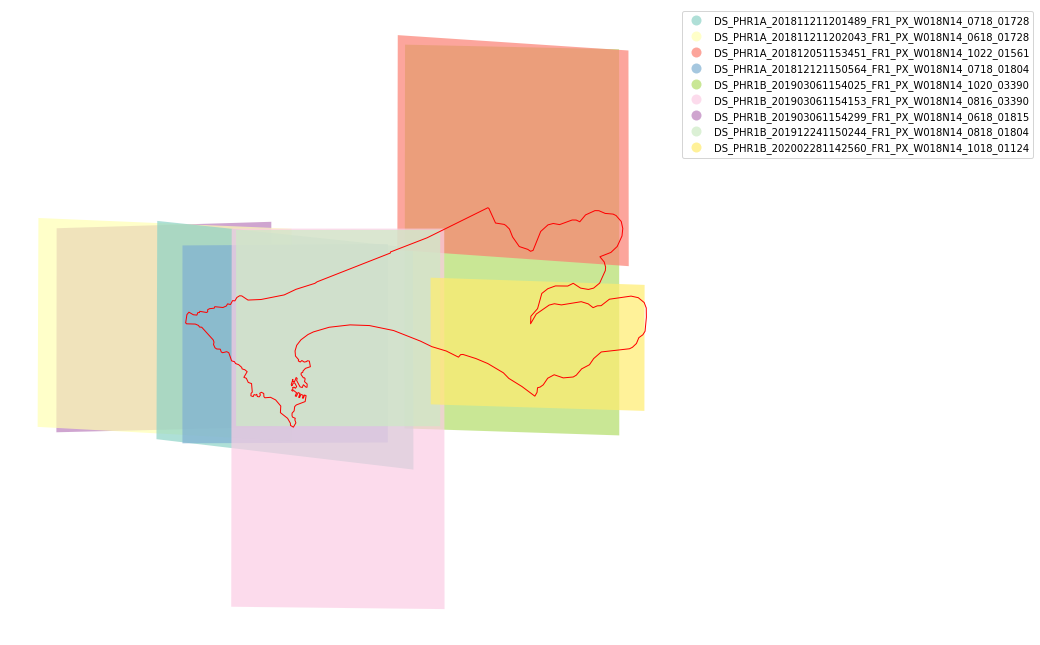

In [5]:
catalog = up42.initialize_catalog()
search_paramaters = catalog.construct_parameter(geometry=aoi, 
                                                start_date="2018-08-02",
                                                end_date="2020-08-09",
                                                sensors=["pleiades"],
                                                max_cloudcover=20,
                                                sortby="cloudCoverage", 
                                                limit=10)
#print(search_paramaters)

search_results = catalog.search(search_paramaters=search_paramaters, as_dataframe=True)
display(search_results.head())

catalog.plot_coverage(scenes=search_results, aoi=aoi)

## Full scene quicklooks

2020-04-02 12:45:39,208 - up42.catalog - INFO - Getting quicklook for ['5a0ef1b8-47d3-4185-adb7-cfd1f1919ab4', 'b23f1aee-2f9d-42f7-9289-5d1869ddb419', '5f6f8e86-aa79-490d-8fbe-cb3d43437ad1', '6da2189e-ead4-4edf-9937-8d468c782553', '3e602dbe-9990-4a30-9d09-7fc100a24529', '1d39ebd5-122b-40ff-a92c-049151b76dfa', '54e01cc4-2671-4114-a7e3-ecee5d9b9dcc', '518476f5-cc02-4d08-833f-a27c17b16726', 'dcc88a3d-d207-4c5f-9256-194ad68f329c']
/Users/christoph.rieke/.virtualenvs/up42-py/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


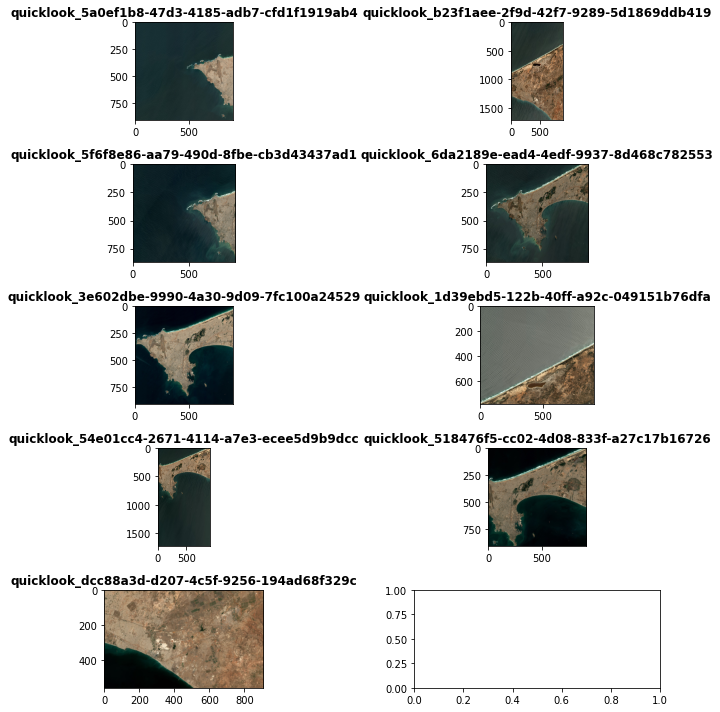

In [6]:
catalog.download_quicklook(image_ids=search_results["id"].tolist(), provider="oneatlas", out_dir=outdir / "quicklooks")
catalog.plot_quicklook(figsize=(10,10))

## Get non-overlapping sections, iteratively prioritizied by cloud cover & area

In [7]:
def add_area_in_sqkm(df: gpd.GeoDataFrame, col_name="area_sqkm") -> gpd.GeoDataFrame:
    
    features = df.__geo_interface__["features"]
    areas_list = []
    for idx, feature in enumerate(features):
        area_sqkm = area.area(feature["geometry"]) / (10 ** 6)
        areas_list.append(area_sqkm)
    
    df[col_name] = areas_list
    return df

,geometry,id,scene_id,cloudCoverage,area_sqkm_clipped
1,"POLYGON ((-17.13618 14.83559, -17.13616 14.814...",b23f1aee-2f9d-42f7-9289-5d1869ddb419,DS_PHR1B_201903061154025_FR1_PX_W018N14_1020_0...,0.0,272.534164
6,"POLYGON ((-17.29503 14.82629, -17.29493 14.716...",54e01cc4-2671-4114-a7e3-ecee5d9b9dcc,DS_PHR1B_201903061154153_FR1_PX_W018N14_0816_0...,0.0,170.618443
7,"POLYGON ((-17.48405 14.70422, -17.48405 14.763...",518476f5-cc02-4d08-833f-a27c17b16726,DS_PHR1B_201912241150244_FR1_PX_W018N14_0818_0...,0.0,163.092085
8,"POLYGON ((-17.30735 14.72025, -17.30745 14.782...",dcc88a3d-d207-4c5f-9256-194ad68f329c,DS_PHR1B_202002281142560_FR1_PX_W018N14_1018_0...,0.0,158.571172
3,"POLYGON ((-17.33200 14.81029, -17.32354 14.809...",6da2189e-ead4-4edf-9937-8d468c782553,DS_PHR1A_201811211201489_FR1_PX_W018N14_0718_0...,0.0,149.447859
4,"POLYGON ((-17.34626 14.80384, -17.34627 14.735...",3e602dbe-9990-4a30-9d09-7fc100a24529,DS_PHR1A_201812121150564_FR1_PX_W018N14_0718_0...,0.0,128.516716
2,"POLYGON ((-17.43358 14.76994, -17.43340 14.687...",5f6f8e86-aa79-490d-8fbe-cb3d43437ad1,DS_PHR1A_201811211202043_FR1_PX_W018N14_0618_0...,0.0,68.849722
5,"POLYGON ((-17.14912 14.79434, -17.33759 14.807...",1d39ebd5-122b-40ff-a92c-049151b76dfa,DS_PHR1A_201812051153451_FR1_PX_W018N14_1022_0...,0.0,65.734988
0,"POLYGON ((-17.45201 14.76441, -17.45195 14.673...",5a0ef1b8-47d3-4185-adb7-cfd1f1919ab4,DS_PHR1B_201903061154299_FR1_PX_W018N14_0618_0...,0.0,45.584635


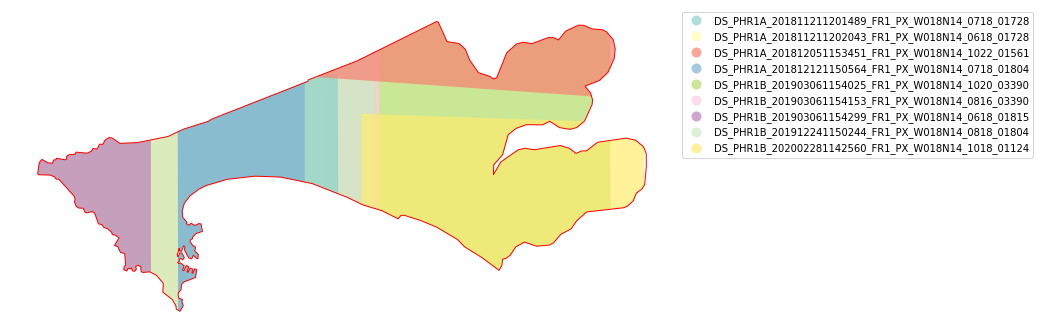

In [8]:
df = search_results[["geometry", "id", "scene_id", "cloudCoverage"]]
df.to_file(driver="GeoJSON", filename=outdir / "search_results.geojson")

# Clip to aoi
clipped = gpd.clip(df, aoi.iloc[0].geometry)
clipped = add_area_in_sqkm(clipped, "area_sqkm_clipped")

# Order by cloudcover & area.
clipped = clipped.sort_values(by=["cloudCoverage", "area_sqkm_clipped"], axis=0, ascending=False)
display(clipped)

catalog.plot_coverage(scenes=clipped, aoi=aoi)

In [9]:
def explode_mp(df: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Explode all multi-polygon geometries in a geodataframe into individual polygon geometries.
    Adds exploded polygons as rows at the end of the geodataframe and resets its index.
    """
    outdf = df[df.geom_type == 'Polygon']

    df_mp = df[df.geom_type == 'MultiPolygon']
    for idx, row in df_mp.iterrows():
        df_temp = gpd.GeoDataFrame(columns=df_mp.columns)
        df_temp = df_temp.append([row] * len(row.geometry), ignore_index=True)
        for i in range(len(row.geometry)):
            df_temp.loc[i, 'geometry'] = row.geometry[i]
        outdf = outdf.append(df_temp, ignore_index=True)

    outdf.reset_index(drop=True, inplace=True)
    return outdf

,geometry,id,scene_id,cloudCoverage,area_sqkm_clipped,area_sqkm_new
0,"POLYGON ((-17.13618 14.83559, -17.13616 14.814...",b23f1aee-2f9d-42f7-9289-5d1869ddb419,DS_PHR1B_201903061154025_FR1_PX_W018N14_1020_0...,0.0,272.534164,272.534164
1,"POLYGON ((-17.33200 14.81029, -17.33084 14.810...",6da2189e-ead4-4edf-9937-8d468c782553,DS_PHR1A_201811211201489_FR1_PX_W018N14_0718_0...,0.0,149.447859,142.206941
2,"POLYGON ((-17.14501 14.76282, -17.12536 14.765...",dcc88a3d-d207-4c5f-9256-194ad68f329c,DS_PHR1B_202002281142560_FR1_PX_W018N14_1018_0...,0.0,158.571172,11.734696
3,"POLYGON ((-17.13618 14.83559, -17.13427 14.833...",1d39ebd5-122b-40ff-a92c-049151b76dfa,DS_PHR1A_201812051153451_FR1_PX_W018N14_1022_0...,0.0,65.734988,0.550263


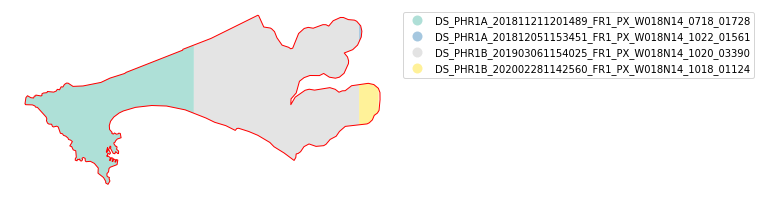

In [10]:
# Iteratively selected the next best scene and add to Dataframe. At each iteration the area criteria is recalculated, as it changes depending on the already
# selected scenes. Often times a scene which has a big area within the aoi is actually not selected, as another scene which has a similar coverage made it
# redundant.

min_size_section = 0.5 #sqkm

# Select the best scene as a starting point (lowest cc, highest area.)
full_coverage = clipped.iloc[[0]]

remaining = clipped.iloc[1:]
    
for i in range(remaining.shape[0]):
        
    # Get the unioned area of the aoi which is already covered by the selected scenes, subtract that area from all remaining scenes.
    already_covered = gpd.GeoDataFrame(pd.DataFrame([0]), crs={'init': 'epsg:4326'}, geometry=[full_coverage.geometry.unary_union])
    remaining_minus_covered = gpd.overlay(remaining, already_covered, how="difference")
    
    # Recalculate the area of the remaining scenes.
    remaining_minus_covered = add_area_in_sqkm(remaining_minus_covered, "area_sqkm_new")
    # Remove too small scene sections 
    remaining_minus_covered = remaining_minus_covered[remaining_minus_covered["area_sqkm_new"] > min_size_section]
    if remaining_minus_covered.shape[0] == 0:
        break
    # reorder.
    remaining_minus_covered = remaining_minus_covered.sort_values(by=["cloudCoverage", "area_sqkm_new"], axis=0, ascending=False)
    
    # Select the now best scene.
    now_best = remaining_minus_covered.iloc[[0]]
    # Explode potential mutipolygons
    if "MultiPolygon" in now_best.geometry.type.tolist():
        now_best = explode_mp(now_best)
        now_best = add_area_in_sqkm(now_best, "area_sqkm_new")
        now_best = now_best[now_best["area_sqkm_new"] > min_size_section]
        if now_best.shape[0] == 0:
            continue
    # Add to the results
    full_coverage = full_coverage.append(now_best)
    full_coverage.reset_index(drop=True, inplace=True)
    
    # Next iteration will not include the selected scene.
    remaining = remaining_minus_covered.iloc[1:]

     
full_coverage = add_area_in_sqkm(full_coverage, "area_sqkm_new")
full_coverage.geometry = full_coverage.geometry.buffer(0)

display(full_coverage)
up42.plot_coverage(full_coverage, aoi=aoi, figsize=(7,7))

## Download sections

In [11]:
#selected_blocks = ["oneatlas-pleiades-aoiclipped"]
selected_blocks = ["oneatlas-pleiades-fullscene", "pansharpen"]

In [12]:
project = up42.initialize_project()
workflow = project.create_workflow("mosaicing", use_existing=True)

blocks=up42.get_blocks(basic=True)
workflow.add_workflow_tasks([blocks[selected] for selected in selected_blocks])

2020-04-02 12:45:51,588 - up42.project - INFO - Using existing workflow: mosaicing, c5e06156-17a0-4a7c-9351-75445d8d7cc6.
2020-04-02 12:45:52,241 - up42.tools - INFO - Getting basic information, use basic=False for all block details.
2020-04-02 12:45:52,881 - up42.tools - INFO - Getting basic information, use basic=False for all block details.
2020-04-02 12:45:53,470 - up42.workflow - INFO - Added tasks to workflow: [{'name': 'oneatlas-pleiades-fullscene:1', 'parentName': None, 'blockId': '8487adcd-a4d7-4cb7-b826-75a533e1f330'}, {'name': 'pansharpen:1', 'parentName': 'oneatlas-pleiades-fullscene:1', 'blockId': '2f24c662-c129-409f-a7c3-afa16a4c78cb'}]


In [ ]:
# Download the different sections for full coverage

jobs = {}
for idx, row in full_coverage.iterrows():

    parameters = workflow.construct_parameter(geometry=row.geometry, 
                                              geometry_operation="intersects", 
                                              scene_ids=[row["scene_id"]])
    print(parameters)

    job = workflow.create_and_run_job(parameters)
    job.track_status(report_time=30)
    
    out_filepaths = job.download_result(out_dir=outdir / "sections")
    jobs[out_filepaths[0]] = job
    
print("finished")

['/Users/christoph.rieke/repos/mosaicing/complex_pleiades_fullscene/sections/ce6b9dea-a63a-4275-aa31-47672a05342d_0.tif', '/Users/christoph.rieke/repos/mosaicing/complex_pleiades_fullscene/sections/83811796-8783-4982-a64a-1e1f4307ea02_0.tif', '/Users/christoph.rieke/repos/mosaicing/complex_pleiades_fullscene/sections/e3b93ac6-8dc9-4089-81d0-5645588bd408_0.tif']


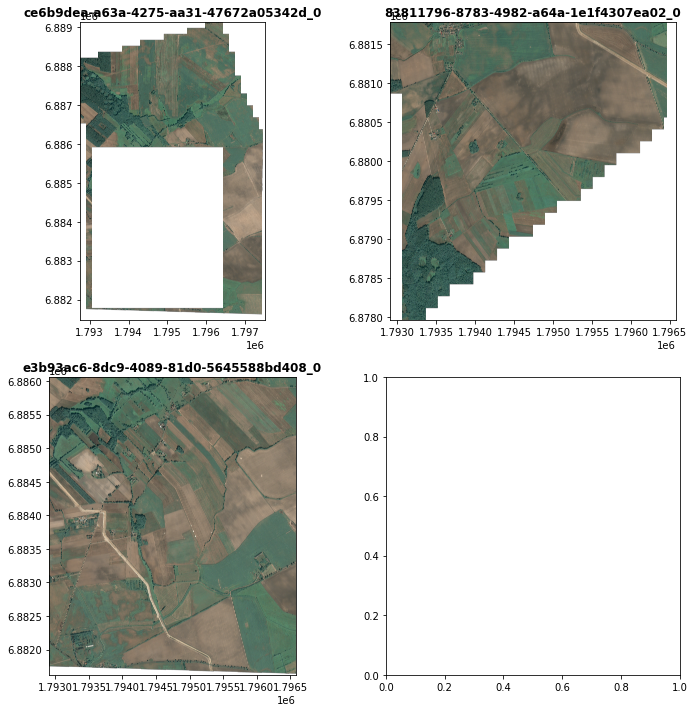

In [12]:
job_results=list(jobs.keys())
print(job_results)

up42.plot_result(figsize=(10,10), filepaths=job_results)

## Mosaic sections

In [13]:
src_files_to_mosaic = []
for fp in job_results:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

    out_profile = src.profile.copy() # bzw. src.meta
print(src_files_to_mosaic)


mosaic, out_transform = merge(src_files_to_mosaic)
print(mosaic.shape)



out_profile.update({
    'height': mosaic.shape[1],
    'width': mosaic.shape[2],
    'transform': out_transform,
    'blockxsize':256,
    'blockysize':256,
    'tiled' : True  # Important for definition block structure!  
})

out_path = outdir / "mosaic_pleiades_complex.tif"
# Write raster.
with rasterio.open(out_path, 'w', **out_profile) as dst:
        for i in range(mosaic.shape[0]):
            dst.write(mosaic[i,...], i+1)

[<open DatasetReader name='/Users/christoph.rieke/repos/mosaicing/complex_pleiades_fullscene/sections/ce6b9dea-a63a-4275-aa31-47672a05342d_0.tif' mode='r'>, <open DatasetReader name='/Users/christoph.rieke/repos/mosaicing/complex_pleiades_fullscene/sections/83811796-8783-4982-a64a-1e1f4307ea02_0.tif' mode='r'>, <open DatasetReader name='/Users/christoph.rieke/repos/mosaicing/complex_pleiades_fullscene/sections/e3b93ac6-8dc9-4089-81d0-5645588bd408_0.tif' mode='r'>]
(4, 18688, 7936)


## Results

Orderids + mosaic arrays

In [14]:
order_ids=[]
if "fullscene" in selected_block:
    for job in jobs.items():
        order_id = job.get_results_json()["features"][0]["orderID"]
        order_ids.append(order_id)
        
print(order_ids)

[]


In [15]:
print(out_path)

/Users/christoph.rieke/repos/mosaicing/complex_pleiades_fullscene/mosaic_pleiades_complex.tif


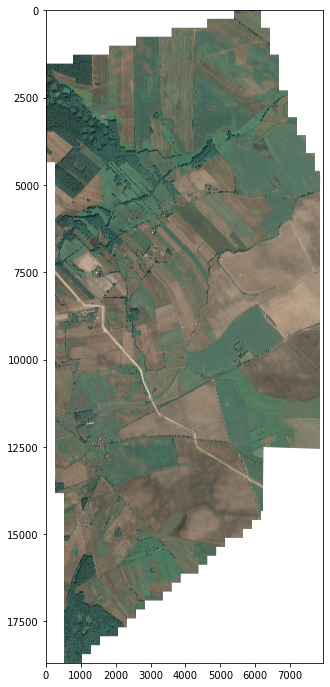

In [16]:
from rasterio.plot import show
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))

show(mosaic, ax=ax)
plt.show()

# TODO:
- Currently clipping the aoi and the overlap leaves a single "polyline" which is filled with wmts tiles. Unnecessary.
- Handle multiple overlaps. Possibly best to not get multiple overlap sections, but change method to get the best coverage of each scene. No overlap sections.